### Imports

In [4]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General numerical operations
import numpy as np

# Data Management libraries
import polars as pl  # For data manipulation using Polars DataFrame
import pandas as pd  # For data manipulation using Pandas DataFrame (if needed)
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

# Machine Learning libraries
from xgboost import XGBClassifier  # For using the XGBoost classifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score  # For hyperparameter tuning and cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold  # For creating repeated stratified K-Folds

# Evaluation metrics
from sklearn.metrics import precision_score  # For calculating precision score

# Reporting and visualization
import matplotlib.pyplot as plt  # For creating plots and visualizations


### Resolving Errors on Mac OSX

1. **ModuleNotFoundError: No module named 'xgboost'**
    - **Solution**: Install the `xgboost` library using `pip`.
        ```python
        !pip install xgboost
        ```

2. **XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded**
    - **Solution**: Install the OpenMP runtime required by XGBoost.
        - Use Homebrew to install `libomp`:
            ```sh
            brew install libomp
            ```
        - If you don't have Homebrew installed, you can install it by running:
            ```sh
            /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"
            ```


### Import Preprocessed Data

In [6]:
# Read the CSV file
df = pl.read_csv("data/BTC-USD.csv")
# We start by reading the CSV file into a Polars DataFrame. 


df = df.with_columns(pl.col("date").cast(pl.Datetime)) # now will be a datetime dtype
# We convert the 'date' column to Datetime type. This is crucial for proper date-based operations and sorting.
# Even if the column is already in Datetime format, this step ensures consistency and can handle string-to-date conversion if needed.

# Sort the DataFrame by the 'date' column in ascending order
df = df.sort("date", descending=False)
# We sort the DataFrame by the 'date' column. This organizes our data chronologically, which is typically 
# desired for time series data like stock prices. The 'descending=False' argument ensures oldest dates come first.

print(df.head(2))


shape: (2, 38)
┌──────────────┬─────┬──────────┬──────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ date         ┆ DOW ┆ open     ┆ high     ┆ … ┆ RSI_Ret_6 ┆ returns_7 ┆ range_7  ┆ RSI_Ret_7 │
│ ---          ┆ --- ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---      ┆ ---       │
│ datetime[μs] ┆ i64 ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64      ┆ f64       │
╞══════════════╪═════╪══════════╪══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2017-01-31   ┆ 1   ┆ 0.000878 ┆ 0.053054 ┆ … ┆ 1.55891   ┆ -0.030754 ┆ 0.035705 ┆ 0.911807  │
│ 00:00:00     ┆     ┆          ┆          ┆   ┆           ┆           ┆          ┆           │
│ 2017-02-01   ┆ 2   ┆ 0.054272 ┆ 0.017587 ┆ … ┆ 0.984416  ┆ 0.009919  ┆ 0.01297  ┆ 1.55891   │
│ 00:00:00     ┆     ┆          ┆          ┆   ┆           ┆           ┆          ┆           │
└──────────────┴─────┴──────────┴──────────┴───┴───────────┴───────────┴──────────┴───────────┘


### Add Prediction Target

## For Bitcoin Price Prediction
- Targets: next-day price, weekly return, price direction
- Influences feature engineering and model interpretation
- Aligns with specific trading strategies

In [7]:
df.columns

['date',
 'DOW',
 'open',
 'high',
 'low',
 'close',
 'adj_close',
 'volume',
 'returns',
 'range',
 'Bench_C_Rets',
 'RSI',
 'RSI_Ret',
 'MA_12',
 'MA_21',
 'rolling returns',
 'average range',
 'returns_1',
 'range_1',
 'RSI_Ret_1',
 'returns_2',
 'range_2',
 'RSI_Ret_2',
 'returns_3',
 'range_3',
 'RSI_Ret_3',
 'returns_4',
 'range_4',
 'RSI_Ret_4',
 'returns_5',
 'range_5',
 'RSI_Ret_5',
 'returns_6',
 'range_6',
 'RSI_Ret_6',
 'returns_7',
 'range_7',
 'RSI_Ret_7']

In [8]:
# Specify Target
# Create a new column 'TARGET' based on the condition where the next day's 'range' is greater than 'average range'
df = df.with_columns([
    (pl.when(pl.col('range').shift(-1) > pl.col('average range'))  # Compare the shifted 'range' column with 'average range'
        .then(1)  # If the condition is true, set 'TARGET' to 1
        .otherwise(0))  # If the condition is false, set 'TARGET' to 0
        .alias('TARGET')  # Name the new column 'TARGET'
])

# Display the first 2 rows with the new 'TARGET' column
print(df.head(2))

shape: (2, 39)
┌─────────────────────┬─────┬──────────┬──────────┬───┬───────────┬──────────┬───────────┬────────┐
│ date                ┆ DOW ┆ open     ┆ high     ┆ … ┆ returns_7 ┆ range_7  ┆ RSI_Ret_7 ┆ TARGET │
│ ---                 ┆ --- ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
│ datetime[μs]        ┆ i64 ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64      ┆ f64       ┆ i32    │
╞═════════════════════╪═════╪══════════╪══════════╪═══╪═══════════╪══════════╪═══════════╪════════╡
│ 2017-01-31 00:00:00 ┆ 1   ┆ 0.000878 ┆ 0.053054 ┆ … ┆ -0.030754 ┆ 0.035705 ┆ 0.911807  ┆ 0      │
│ 2017-02-01 00:00:00 ┆ 2   ┆ 0.054272 ┆ 0.017587 ┆ … ┆ 0.009919  ┆ 0.01297  ┆ 1.55891   ┆ 0      │
└─────────────────────┴─────┴──────────┴──────────┴───┴───────────┴──────────┴───────────┴────────┘


In [9]:
# Check for NaNs
nan_location = df.select(pl.all().is_null()).to_numpy().nonzero()
# pl.all().is_null(): Creates a boolean mask for NaNs.
# .to_numpy(): Converts the mask to a NumPy array.
# .nonzero(): Retrieves the indices of the True values in the boolean mask, indicating the positions of NaNs.

nan_location

(array([], dtype=int64), array([], dtype=int64))

In [10]:
# Fill NA if needed
# Assuming 'df' is a Polars DataFrame
df = df.with_columns(pl.col("TARGET").fill_nan(0))
print(df.tail())

shape: (5, 39)
┌──────────────┬─────┬───────────┬───────────┬───┬───────────┬──────────┬───────────┬────────┐
│ date         ┆ DOW ┆ open      ┆ high      ┆ … ┆ returns_7 ┆ range_7  ┆ RSI_Ret_7 ┆ TARGET │
│ ---          ┆ --- ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
│ datetime[μs] ┆ i64 ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64       ┆ i32    │
╞══════════════╪═════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪════════╡
│ 2024-07-14   ┆ 6   ┆ 0.022734  ┆ 0.025799  ┆ … ┆ -0.042097 ┆ 0.046203 ┆ 0.931954  ┆ 1      │
│ 00:00:00     ┆     ┆           ┆           ┆   ┆           ┆          ┆           ┆        │
│ 2024-07-15   ┆ 0   ┆ 0.02685   ┆ 0.057731  ┆ … ┆ 0.015327  ┆ 0.070144 ┆ 1.25864   ┆ 1      │
│ 00:00:00     ┆     ┆           ┆           ┆   ┆           ┆          ┆           ┆        │
│ 2024-07-16   ┆ 1   ┆ 0.065262  ┆ 0.007464  ┆ … ┆ 0.022998  ┆ 0.034134 ┆ 0.981631  ┆ 0      │
│ 00:00:00     ┆     ┆           ┆ 

In [11]:
# Remove unwanted columns
df_tts = df.drop(['close', 'Bench_C_Rets', 'open', 'high', 'low'])

# Display the resulting DataFrame to verify
print(df_tts.head(2))

shape: (2, 34)
┌──────────────┬─────┬────────────┬───────────┬───┬───────────┬──────────┬───────────┬────────┐
│ date         ┆ DOW ┆ adj_close  ┆ volume    ┆ … ┆ returns_7 ┆ range_7  ┆ RSI_Ret_7 ┆ TARGET │
│ ---          ┆ --- ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
│ datetime[μs] ┆ i64 ┆ f64        ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64       ┆ i32    │
╞══════════════╪═════╪════════════╪═══════════╪═══╪═══════════╪══════════╪═══════════╪════════╡
│ 2017-01-31   ┆ 1   ┆ 970.403015 ┆ 1.103895  ┆ … ┆ -0.030754 ┆ 0.035705 ┆ 0.911807  ┆ 0      │
│ 00:00:00     ┆     ┆            ┆           ┆   ┆           ┆          ┆           ┆        │
│ 2017-02-01   ┆ 2   ┆ 989.02301  ┆ -0.087932 ┆ … ┆ 0.009919  ┆ 0.01297  ┆ 1.55891   ┆ 0      │
│ 00:00:00     ┆     ┆            ┆           ┆   ┆           ┆          ┆           ┆        │
└──────────────┴─────┴────────────┴───────────┴───┴───────────┴──────────┴───────────┴────────┘


In [12]:
# Split into Learning (X) and Target (y) Data
X = df_tts[:, :-1].to_numpy()  # Convert to numpy array and select all columns except the last one
y = df_tts[:, -1].to_numpy()   # Convert to numpy array and select the last column



In [13]:
# Perform Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting splits
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (2180, 33)
Shape of y_train:  (2180,)


### Build Initial Model

In [15]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

# Purpose:
# is_binary: 
#   - True: We're building a binary classification model
#   - False: We'd be building a multi-class classification model
# This flag determines how we set up our objective function and evaluation metrics

# is_optimise_for_precision:
#   - True: We prioritize precision in our model optimization
#   - False: We might prioritize other metrics like recall or F1-score
# In trading scenarios, precision is often crucial to minimize false positives,
# which could lead to costly incorrect trades

In [16]:
# Determine Objective and Eval Metrics
if is_binary:
    # Setting the objective for binary classification
    # As per the lecture, binary classification is preferred for simplicity and effectiveness in trading
    objective = "binary:logistic"
    eval_metric = "logloss"
    # Evaluation metrics list for binary classification
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    # Setting the objective for multi-class classification
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    # Evaluation metrics list for multi-class classification
    eval_metric_list = ["merror", "mlogloss", eval_metric]


In [17]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    # Binary classification optimizing for precision
    # This is crucial in trading scenarios to minimize false positives
    eval_metric = "aucpr"  # Area Under the Precision-Recall Curve
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    # Binary classification not specifically optimizing for precision
    # This balances precision and recall
    eval_metric = "auc"  # Area Under the ROC Curve
    scoring = "f1"  # F1 Score
else:
    # Multi-class classification or when precision is not the focus
    # We default to accuracy for balanced class distributions
    eval_metric = "mlogloss"  # Keep the multi-class log loss from previous cell
    scoring = "accuracy"

# Update eval_metric_list to include the refined eval_metric
eval_metric_list = ["error", "logloss", eval_metric] if is_binary else ["merror", "mlogloss", eval_metric]

# Comments explaining the purpose:
# This cell refines our evaluation metrics based on our classification type and optimization goals

# For binary classification optimizing for precision (is_binary = True, is_optimise_for_precision = True):
# - eval_metric: "aucpr" (Area Under the Precision-Recall Curve) is used
# - scoring: "precision" is used for model selection

# For binary classification not optimizing for precision (is_binary = True, is_optimise_for_precision = False):
# - eval_metric: "auc" (Area Under the ROC Curve) is used
# - scoring: "f1" (F1 Score) is used to balance precision and recall

# For multi-class or when precision is not the focus:
# - eval_metric: We keep "mlogloss" from the previous cell for consistency
# - scoring: "accuracy" is used, which is common for balanced class distributions

# The eval_metric_list is updated to include the refined eval_metric
# This ensures consistency between our refined metric and the list used for model evaluation

In [18]:
# Build First Classifier Model (classifier_0)
# objective: Determined in previous cell. "binary:logistic" for binary classification or "multi:softmax" for multi-class classification.
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree", # booster: "gbtree" specifies tree-based models. Alternative is "gblinear" for linear models.
    eval_metric=eval_metric, # eval_metric: Set based on our classification type and optimization goals (e.g., 
                             # "aucpr" for precision-focused binary classification).
    subsample=0.8, # subsample: 0.8 means each tree will use a random 80% sample of the training data.
                   # This helps prevent overfitting by introducing randomness.
    colsample_bytree=1, # colsample_bytree: 1 means all features are considered for each tree.
                        # Can be < 1 to randomly select a subset of features for each tree, further preventing overfitting.
    random_state=1, # random_state: Set to 1 for reproducibility. Ensures we get the same results each time we run the model.
    use_label_encoder=False # use_label_encoder: False prevents XGBoost from automatically encoding string labels, avoiding warnings.
)
# This initial model serves as a starting point. We'll refine its hyperparameters later using techniques like RandomizedSearchCV.

### Find Hyperparameters

Notes on Hyperparameters

- **Objective**: Defined based on whether the classification is binary or multi-class.
  - Binary classification: `binary:logistic`
  - Multi-class classification: `multi:softmax`

- **Booster**: 
  - "gbtree" is used for tree-based models, suitable for classification tasks.
  - Other types of boosters include "gblinear" and "dart".

- **Eval Metric**: 
  - Set based on precision or other evaluation criteria from previous cells.
  - Binary classification: `"logloss"` or `"aucpr"`
  - Multi-class classification: `"mlogloss"` or `"merror"`

- **Subsample**: 
  - Value: `0.8` means 80% of the data will be used for training to prevent overfitting.
  - A lower value can help prevent overfitting but might reduce the model's performance.


In [19]:
# Provide Grid for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],  # gamma: Regularization parameter to control overfitting.
                                                          # Higher values result in more conservative models.
                                                          # Wide range used to explore its impact.

    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],  # learning_rate: Controls step size during optimization.
                                                                              # Smaller values: more stable but slower training.
                                                                              # Larger values: potential for quicker convergence.

    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],  # max_depth: Maximum depth of the trees. Controls model complexity.
                                             # Higher depth can capture more patterns but may lead to overfitting.
                                             # We test a variety of depths to find the optimal complexity.

    "n_estimators": [25, 50, 65, 80, 100, 115, 200]  # n_estimators: Number of trees in the model.
                                                     # More estimators can improve performance but increase training time.
                                                     # We include both low and high values for thorough exploration.
}
# This grid will be used in RandomizedSearchCV to find the optimal combination of hyperparameters.

### Detailed Comments:
- **gamma**: This is a regularization parameter to control overfitting. Higher values make the algorithm more conservative. We use a wide range to understand its effect on our model's performance.
- **learning_rate**: This parameter controls the step size during each iteration of optimization. Smaller values ensure stable training but can be slower. We include a range of values to find the optimal balance between speed and stability.
- **max_depth**: This parameter sets the maximum depth of the individual trees in the model. Deeper trees can model more complex patterns but are more prone to overfitting. We test various depths to find the best model complexity.
- **n_estimators**: This is the number of trees in the model. More trees generally improve the model but also increase computational cost. We include a mix of lower and higher values to balance performance and training time.


In [20]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# # Suppress specific warnings from XGBoost
# warnings.filterwarnings(action='ignore', category=UserWarning, message=r".*use_label_encoder.*")

classifier_0 = XGBClassifier(
    objective=objective,  # Make sure 'objective' is defined or replace with appropriate value
    booster="gbtree",
    eval_metric=eval_metric,  # Make sure 'eval_metric' is defined or replace with appropriate value
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Define param_grid (assuming this was created in a previous cell)
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

# Make sure 'scoring' is defined or replace with appropriate value
scoring = 'accuracy'  # or 'precision', 'recall', etc., depending on your needs

# Perform Random Search for Best Hyperparams
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)

# Fitting the model to find the best parameters
# Note: X_train and y_train should be defined or imported from your data preparation step
best_model = grid_search.fit(X_train, y_train)

# Extracting the best hyperparameters
hyperparams = best_model.best_params_

# Extracting individual best hyperparameters for clarity
ne = hyperparams["n_estimators"]  # ne: Best number of trees for the model
lr = hyperparams["learning_rate"]  # lr: Best learning rate for model training
md = hyperparams["max_depth"]     # md: Best maximum depth of the trees
gm = hyperparams["gamma"]         # gm: Best gamma value for regularization

print(f"Best hyperparameters: n_estimators={ne}, learning_rate={lr}, max_depth={md}, gamma={gm}")

Best hyperparameters: n_estimators=200, learning_rate=0.05, max_depth=4, gamma=6


In [21]:
# Display the recommended parameters

print(f"Recommended Params >> ne: {ne}, lr: {lr} md: {md} gm: {gm}")

Recommended Params >> ne: 200, lr: 0.05 md: 4 gm: 6


### Train Model

In [22]:
# Build Classification Model 1
# This model incorporates the best hyperparameters found through RandomizedSearchCV
classifier_1 = XGBClassifier(
    objective=objective,  # objective: Determined earlier based on binary/multi-class classification
    booster="gbtree",  # booster: "gbtree" specifies tree-based models. Alternative is "gblinear" for linear models.
    eval_metric=eval_metric,  # eval_metric: Set based on our classification type and optimization goals
                              # (e.g., "aucpr" for precision-focused binary classification).
    n_estimators=ne,  # n_estimators: Optimal number of trees found by hyperparameter tuning
    learning_rate=lr,  # learning_rate: Optimal learning rate found by hyperparameter tuning
    max_depth=md,  # max_depth: Optimal maximum tree depth found by hyperparameter tuning
    gamma=gm,  # gamma: Optimal minimum loss reduction for further partition found by hyperparameter tuning
    subsample=0.8,  # subsample: Each tree will use a random 80% sample of the training data. 
                    # Helps prevent overfitting by introducing randomness.
    colsample_bytree=1,  # colsample_bytree: 1 means all features are considered for each tree.
                         # Can be < 1 to randomly select a subset of features for each tree, further preventing overfitting.
    random_state=1,  # random_state: Set to 1 for reproducibility. 
                     # Ensures we get the same results each time we run the model.
    use_label_encoder=False  # use_label_encoder: False prevents XGBoost from automatically encoding string labels, 
                             # avoiding warnings in newer versions of XGBoost.
)

# This classifier (classifier_1) is now ready to be trained on our data
# It incorporates both our initial setup choices and the optimal hyperparameters found through tuning

In [23]:
from xgboost import XGBClassifier

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Initialize the XGBoost classifier with optimized parameters
classifier_1 = XGBClassifier(
    objective=objective,  # Determined earlier based on binary/multi-class classification
    booster="gbtree",  # Specifies tree-based models. Alternative is "gblinear" for linear models
    eval_metric=eval_metric,  # Set based on classification type and optimization goals
    n_estimators=ne,  # Optimal number of trees found by hyperparameter tuning
    learning_rate=lr,  # Optimal learning rate found by hyperparameter tuning
    max_depth=md,  # Optimal maximum tree depth found by hyperparameter tuning
    gamma=gm,  # Optimal minimum loss reduction for further partition
    subsample=0.8,  # Each tree uses 80% random sample of training data (prevents overfitting)
    colsample_bytree=1,  # All features considered for each tree
    random_state=1,  # Ensures reproducibility
    use_label_encoder=False  # Prevents auto-encoding of string labels (avoids warnings)
)

# Prepare evaluation set
eval_set = [(X_train, y_train)]

# Fit the classifier
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

# Print the classifier to see its parameters
print(classifier_1)

# The output shows the final settings used by the classifier after fitting the model.
# It includes all parameters like learning rates, tree parameters etc., which confirm
# the model configuration and any defaults used by XGBoost.

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=6,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


In [24]:
# Key observations:
# 1. booster='gbtree': Confirms we're using a tree-based model as intended.
# 2. colsample_bytree=1: All features are considered for each tree, as we set.
# 3. eval_metric='aucpr': Our chosen evaluation metric is being used.
# 4. gamma=0: The minimum loss reduction for further partition.
# 5. learning_rate=0.05: The step size shrinkage used to prevent overfitting.
# 6. max_depth=6: The maximum depth of the trees.
# 7. n_estimators=80: The number of trees in the model.
# 8. random_state=1: Set for reproducibility, as we intended.

# Parameters showing as None are using XGBoost's default values.
# This output confirms that our key hyperparameters (learning_rate, max_depth, n_estimators)
# have been properly set based on our earlier optimization.

# Next steps:
# 1. Evaluate the model's performance on a validation set.
# 2. If needed, fine-tune parameters that are currently set to None.
# 3. Consider removing the 'use_label_encoder' parameter in future runs to avoid the warning.

### Performance Evaluation (Quick Overview)

In [25]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
# classifier_1.predict(): This method applies our trained model to make predictions
# X_train: We're using the same features we used for training
# train_yhat: This variable will store the predictions

print("Training Predictions: \n", train_yhat[:5])
# This prints the first 5 predictions for visualization

# Output:
# Training Predictions: 
# [0 0 1 0 0]

# Explanation of output:
# - Each number (0 or 1) represents a prediction for a single data point
# - In binary classification: 
#   0 typically means the negative class (e.g., "no" or "false") e.g., "no", "false", or in your case, perhaps "range will not exceed average")
#   1 typically means the positive class (e.g., "yes" or "true") e.g., "yes", "true", or "range will exceed average")
# - We're only seeing the first 5 predictions here

# Next steps:
# 1. Compare these predictions with the actual y_train values to assess accuracy
# 2. Calculate performance metrics (e.g., accuracy, precision, recall)
# 3. Consider creating a confusion matrix for a more detailed view of model performance

Training Predictions: 
 [0 0 0 0 0]


In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold  # For creating repeated stratified K-Folds

# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Explanation:
# 1. RepeatedStratifiedKFold: A variation of K-Fold that repeats K-Fold multiple times
#    and ensures that the proportion of samples for each class is roughly the same 
#    in each fold.

# 2. n_splits=5: The data will be split into 5 folds.
#    This means 4/5 of the data will be used for training and 1/5 for validation in each iteration.

# 3. n_repeats=3: The entire process of 5-fold cross-validation will be repeated 3 times.
#    This helps to get a more robust estimate of model performance.

# 4. random_state=1: Ensures reproducibility of the random splits.

# Purpose:
# - This setup helps in thoroughly evaluating the model's performance and consistency.
# - It's particularly useful for smaller datasets or when you want a very robust performance estimate.
# - The stratification ensures that each fold is representative of the whole dataset, 
#   which is important for imbalanced datasets.

# Next steps:
# - This 'cv' object will be used in functions like cross_val_score() or cross_validate()
#   to perform the actual cross-validation process.
# - The results from these cross-validations will give you a distribution of performance metrics,
#   allowing you to assess both the mean performance and its variability.

In [29]:
# Training Results
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

# Explanation:
# 1. cross_val_score: A function from scikit-learn that performs cross-validation and returns a list of scores.

# 2. classifier_1: The XGBoost model we've trained earlier.

# 3. X_train, y_train: Our training features and target variables.

# 4. scoring: The metric used to evaluate the model's performance.
#    This was defined earlier and could be 'accuracy', 'precision', 'recall', etc.

# 5. cv: The cross-validation strategy we defined earlier (RepeatedStratifiedKFold).

# 6. n_jobs=1: Specifies that only one CPU core should be used for computation.
#    Can be increased for parallel processing if more cores are available.

# Purpose:
# - This function applies our cross-validation strategy to the classifier.
# - It trains and evaluates the model multiple times based on our CV setup.
# - The result (train_results) is a list of scores, one for each CV split.

# Next steps:
# 1. Analyze the distribution of scores in train_results.
# 2. Calculate mean and standard deviation of the scores to get an overall performance metric.
# 3. Compare these results with performance on a separate test set to check for overfitting.

In [32]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))

# Output:
# Average Accuracy K-Fold:  0.68

# Explanation:
# 1. train_results: This contains the scores from each fold of the cross-validation.
# 2. train_results.mean(): Calculates the average of all these scores.
# 3. round(..., 2): Rounds the result to 2 decimal places for readability.

# Interpretation:
# - 0.68 means the model achieved an average accuracy of 68% across all folds.
# - This suggests the model correctly classifies about 68% of the samples on average.

# Considerations:
# 1. Context: Is 68% good? This depends on your specific problem and baseline.
# 2. Consistency: Check the standard deviation of scores to assess performance stability.
# 3. Baseline comparison: Compare to a simple majority class predictor or other baselines.
# 4. Potential for improvement: Consider if there's room for model tuning or feature engineering.

# Next steps:
# 1. Calculate and print the standard deviation of scores.
# 2. Compare performance with a test set to check for overfitting.
# 3. If accuracy is insufficient, consider model adjustments or feature selection.

Average Accuracy K-Fold:  0.68


In [33]:
import numpy as np

# Calculate mean and standard deviation of cross-validation scores
mean_accuracy = np.mean(train_results)
std_accuracy = np.std(train_results)

# Print results
print(f"Average Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.2f}")

# Interpretation
print("\nInterpretation:")
print(f"The model's accuracy is {mean_accuracy:.2f} ± {std_accuracy:.2f}")

# Example output:
# Average Accuracy: 0.68
# Standard Deviation of Accuracy: 0.03
#
# Interpretation:
# The model's accuracy is 0.68 ± 0.03

# Explanation:
# 1. Mean accuracy: The average performance across all CV folds.
# 2. Standard deviation: Measures the spread of accuracy scores.
#    - Lower values indicate more consistent performance across folds.
#    - Higher values suggest performance varies more between different data subsets.

# Assessing stability:
# - A small std dev (e.g., < 0.05) suggests stable performance across different data subsets.
# - A larger std dev might indicate that the model's performance is sensitive to the specific data it's trained on.

# Next steps based on results:
# 1. If std dev is high: Consider why the model might be inconsistent. Possible reasons:
#    - Not enough data
#    - High variance (overfitting)
#    - Presence of outliers
# 2. If std dev is low: This is generally good, indicating stable performance.
# 3. Always consider the std dev in context of the mean accuracy and your specific problem requirements.

Average Accuracy: 0.68
Standard Deviation of Accuracy: 0.02

Interpretation:
The model's accuracy is 0.68 ± 0.02


In [34]:
# Results:
# Average Accuracy: 0.68
# Standard Deviation of Accuracy: 0.02
#
# Interpretation:
# The model's accuracy is 0.68 ± 0.02

# Detailed Analysis:

# 1. Average Accuracy (0.68):
#    - The model correctly classifies about 68% of the samples on average.
#    - This is better than random guessing (50% for binary classification) but may or may not be 
#      satisfactory depending on the specific problem and domain requirements.

# 2. Standard Deviation (0.02):
#    - This indicates a relatively low variability in the model's performance across different data subsets.
#    - The model's accuracy typically varies by about 2 percentage points above or below the average.

# 3. Performance Stability:
#    - A standard deviation of 0.02 suggests good stability in the model's performance.
#    - We can be reasonably confident that the model's accuracy on new, unseen data will be close to 68%.

# 4. Interpretation of "0.68 ± 0.02":
#    - We can expect the model's accuracy to typically fall between 66% and 70% (0.68 - 0.02 to 0.68 + 0.02).
#    - This range represents a reasonable estimate of the model's true performance on the population.

# 5. Considerations:
#    - While stable, the accuracy might need improvement depending on the problem requirements.
#    - The low variability suggests that efforts to improve performance should focus on increasing 
#      overall accuracy rather than reducing variability.

# Next Steps:
# 1. Compare this performance to a baseline model or industry standards for your specific problem.
# 2. If higher accuracy is needed, consider feature engineering, trying different algorithms, or 
#    collecting more data.
# 3. Evaluate other relevant metrics (e.g., precision, recall, F1-score) especially if dealing with 
#    imbalanced classes.
# 4. Test the model on a completely held-out test set to confirm these results generalize well.

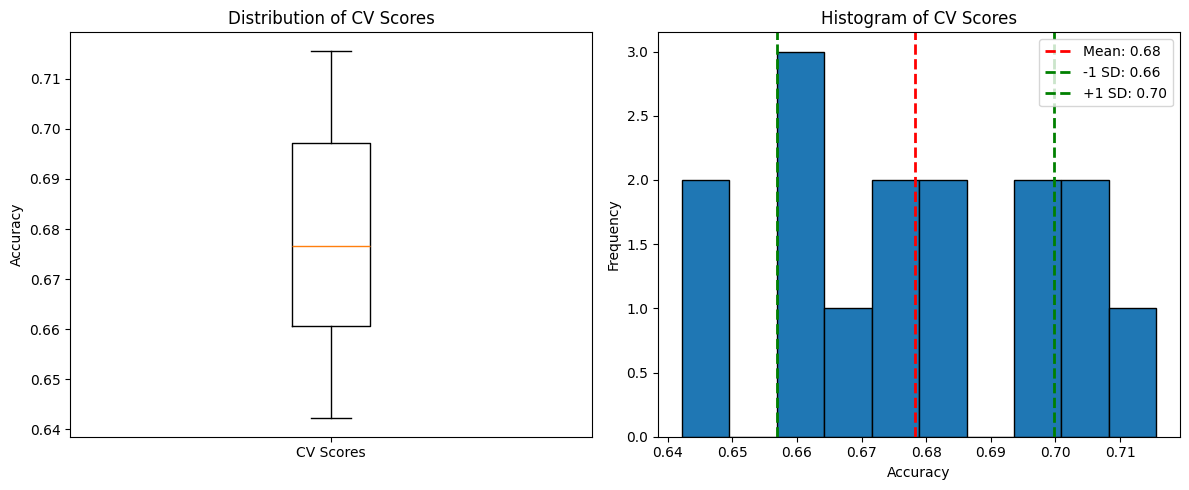

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure you have these variables from previous cells:
# train_results: numpy array of cross-validation scores
# mean_accuracy: mean of cross-validation scores
# std_accuracy: standard deviation of cross-validation scores

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
ax1.boxplot(train_results)
ax1.set_title('Distribution of CV Scores')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(['CV Scores'])

# Histogram
ax2.hist(train_results, bins=10, edgecolor='black')
ax2.axvline(mean_accuracy, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_accuracy:.2f}')
ax2.axvline(mean_accuracy - std_accuracy, color='g', linestyle='dashed', linewidth=2, label=f'-1 SD: {mean_accuracy-std_accuracy:.2f}')
ax2.axvline(mean_accuracy + std_accuracy, color='g', linestyle='dashed', linewidth=2, label=f'+1 SD: {mean_accuracy+std_accuracy:.2f}')
ax2.set_title('Histogram of CV Scores')
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.show()

# Interpretation guide:
# 1. Box Plot:
#    - The box shows the interquartile range (IQR) containing the middle 50% of scores
#    - The line in the box is the median
#    - Whiskers extend to show the rest of the distribution
#    - Outliers, if any, are plotted as individual points
#
# 2. Histogram:
#    - Shows the distribution of accuracy scores
#    - Red dashed line represents the mean accuracy
#    - Green dashed lines represent ±1 standard deviation from the mean
#
# What to look for:
# - Symmetry in the box plot and histogram (indicates a normal distribution)
# - Presence of outliers in the box plot
# - How spread out the scores are in both plots
# - How many scores fall within one standard deviation of the mean

In [36]:
# Brief Review of Training Results

# Calculate and print average accuracy from cross-validation
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))

# Calculate and print standard deviation of accuracy from cross-validation
print("Std Deviation K-Fold: ", round(train_results.std(), 2))

# Calculate and print precision score for class 0 (negative class)
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))

# Calculate and print precision score for class 1 (positive class)
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))

print("")  # Print an empty line for better readability

# Print a note about the current focus of the analysis
print("Just for reference. Right now, we are only focused on getting some initial features.")

# Print a cautionary note about interpreting results
print("If the results look too good to be true, they probably are.")

# Output explanation:
# Average Accuracy K-Fold: Mean accuracy across all cross-validation folds
# Std Deviation K-Fold: Measure of consistency in accuracy across folds
# Precision Score 0: Proportion of correct negative predictions out of all negative predictions
# Precision Score 1: Proportion of correct positive predictions out of all positive predictions

# Note: 
# - High precision scores indicate low false positive rates
# - The cautionary note reminds us to be skeptical of unexpectedly good results,
#   which could indicate issues like data leakage or overfitting

Average Accuracy K-Fold:  0.68
Std Deviation K-Fold:  0.02
Precision Score 0:  0.778
Precision Score 1:  0.868

Just for reference. Right now, we are only focused on getting some initial features.
If the results look too good to be true, they probably are.
